In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
#load in the dataset
data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


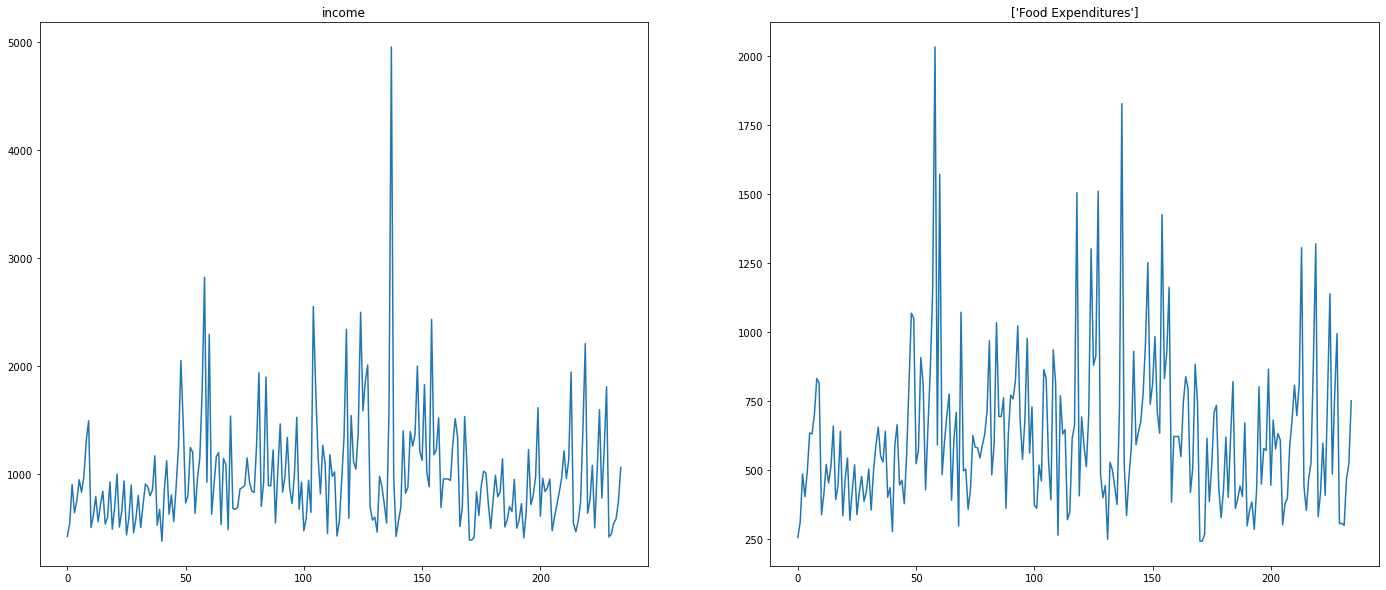

In [24]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (24,10))

axs[0].plot(data['income'])
axs[0].set_title("income")

axs[1].plot(data['foodexp'])
axs[1].set_title('Food Expenditures')

plt.show()

In [10]:
#then they use least absolute deviation
mod = smf.quantreg('foodexp ~ income', data)

#and they use a q value of 0.5
res = mod.fit(q = 0.5)

#print results
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Fri, 04 Jun 2021   No. Observations:                  235
Time:                        09:30:53   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [14]:
#let's make quantiles that we are interested in
quantiles = np.arange(0.05, 0.96, 0.1)

#make function to fit the data
def fit_model(q):
    
    #fit the model
    res = mod.fit(q = q)
    
    #then return the values
    return [q, res.params['Intercept'], res.params['income']] + res.conf_int().loc['income'].tolist()

In [15]:
#it looks like we are going to pass the quantiles through the function we made
models = [fit_model(x) for x in quantiles]

#not sure what these are but it looks like lower bound / upper bound 
models = pd.DataFrame(models, columns = ['q', 'a', 'b', 'lb', 'ub'])

In [18]:
ols = smf.ols('foodexp ~ income', data).fit()
ols

In [19]:
ols_ci = ols.conf_int().loc['income'].to_list()
ols_ci

[0.4568738130184233, 0.5134830343354237]

In [20]:
ols = dict(a = ols.params['Intercept'], b = ols.params['income'], lb = ols_ci[0], ub = ols_ci[1])

In [22]:
models

,q,a,b,lb,ub
0,0.05,124.880100,0.343361,0.268632,0.418090
1,0.15,111.693660,0.423708,0.382780,0.464636
2,0.25,95.483539,0.474103,0.439900,0.508306
3,0.35,105.841294,0.488901,0.457759,0.520043
4,0.45,81.083647,0.552428,0.525021,0.579835
5,0.55,89.661370,0.565601,0.540955,0.590247
6,0.65,74.033435,0.604576,0.582169,0.626982
7,0.75,62.396584,0.644014,0.622411,0.665617
8,0.85,52.272216,0.677603,0.657383,0.697823
9,0.95,64.103964,0.709069,0.687831,0.730306


In [23]:
ols

{'a': 147.47538852370573,
 'b': 0.48517842367692354,
 'lb': 0.4568738130184233,
 'ub': 0.5134830343354237}

In [28]:
#make a range that goes from the min to max with 50 spots
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

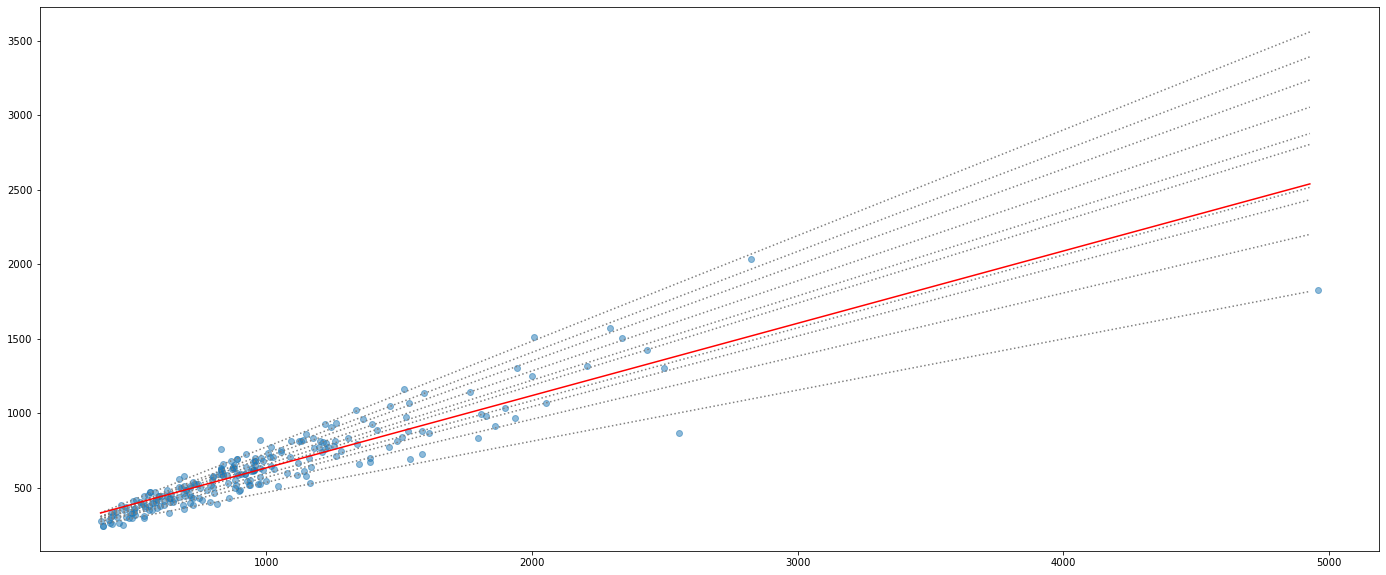

In [37]:
fig, axs = plt.subplots(figsize = (24,10))

for i in range(models.shape[0]):
    
    y = get_y(models.a[i], models.b[i])
    axs.plot(x,y, linestyle = 'dotted', color = 'grey')
    
y = get_y(ols['a'], ols['b'])

axs.plot(x,y, color = 'red', label = 'OLS')
axs.scatter(data.income, data.foodexp, alpha = 0.5)

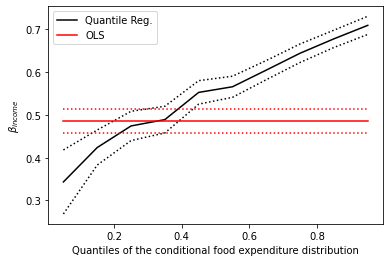

<Figure size 1728x720 with 0 Axes>

In [39]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.figure(figsize = (24,10))
plt.show()